# T09P02 - MdSM

# CASO DE ESTUDIO 2: Tiempo crítico de despeje de una falta trifásica en el punto medio de la línea B (de un conjunto de dos líneas en paralelo) y que se despeja por apertura de la misma.

## Enunciado

Determine el ángulo crítico de despeje de una falta trifásica en el punto medio de la línea B de un grupo de dos líneas en paralelo, y que se despeja por apertura de la misma.

Tome como datos:

- Potencia nominal del generador ($S_g$): 100 MVA.
- Tensión nominal en bornes del generador ($U_g$): 15 kV.
- Constante de inercia del generador ($H_g$): 3 s (Referida a la potencia del generador).
- Carga del generador previa a la falta: 100% potencia nominal.
- Factor de potencia del generador previo a la falta: $0.8$ inductivo.
- Reactancia transitoria del generador ($X'_g$): 0.3 pu.
- Potencia del transformador ($S_t$): 100 MVA.
- Reactancia de cc del transformador ($X_t$): 0.15 pu.
- Reactancia de la línea A ($X_{lA}$): 0.20 pu.
- Reactancia de la línea B ($X_{lB}$): 0.20 pu.
- Tensión del nudo de conexión ($U_{red}$): 220 kV.
- Potencia del nudo de conexión ($S_{red}$): infinita.

**Sistema eléctrico:**

![Esquema del sistema](T09P02_Fig00.png)

## Resolución

In [381]:
# Importar librerías genéricas:
import numpy as np
import cmath as cm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optim

# Formato general de salida de resultados numéricos:
np.set_printoptions(precision=3, suppress=True)

### Datos del problema

In [382]:
# Datos:
Sgen = 100 # MVA.
Ugen = 15 # kV.
H = 3 # s.
Xgen = 0.3 # pu (transitoria).
Ured = 220 # kV.
St = 100 # MVA.
Xt = 0.15 # pu.
XlA = 0.20 # pu.
XlB = 0.20 # pu.
dist_falta = 0.5 # Posición de la falta en la línea (distancia relativa desde cabecera).
FPgen = 0.8 # factor de potencia del generador.
Gen = 1 # Régimen de carga del generador (tanto por uno).
f = 50 # Hz.
omega_0 = 2*np.pi*f # Velocidad angular eléctrica de sincronismo (rad/s).

### Transformación a valores por unidad

In [383]:
# Magnitudes base:
Sbase = 100 # Potencia base (MVA).
Ub1 = Ugen # Tensión base zona 1 (generador) (kV).
Ub2 = Ured # Tensión base zona 2 (red) (kV).

# Magnitudes transformadas:
ugen = Ugen/Ub1 # Tensión del generador.
ured = Ured/Ub2 # Tensión de red.
sgen = Sgen/Sbase # Potencia entregada por el generador pre-falta.
H = H*Sgen/Sbase # Constante de inercia referida a la potencia base del sistema.

### Condiciones pre-falta

Antes de concurrir la situación de falta debe determinarse el punto de operación del sistema, que vendrá determinado por la capacidad de transferencia de potencia:

$$P_{elec}=\displaystyle\frac{E_{G}\cdot U_{RED}}{X_{03,pref}}\sin\left(\delta_0\right),$$
siendo $E_{G}$ (pu) la fuerza electromotriz entregada por el generador (antes de su impedancia interna), $U_{RED}$ (pu) la tensión del punto de conexión a red (que al considerarse de potencia infinita, se mantiene durante toda la condición de estudio), $X_{03,pref}$ (pu) la reactancia de transferencia entre los nodos **0** (antes de la impedancia interna del generador) y **3** (punto de conexión a red) previo a la falta (se tomará la reactancia transitoria del generador) y $\delta_0$ (rad) que es el ángulo eléctrico de desfase entre la fuerza electromotriz del generador y la tensión del punto de conexión a red.

Obsérvese que, en condiciones pre-falta:
 
1. $X_{01}=X'_{G}+X_{T1}+\displaystyle\frac{X_{L23A} X_{L23B}}{X_{L23A} + X_{L23B}}$.
2. $\mathcal{I}_{03}=\left(\displaystyle\frac{\mathcal{S}_{G}}{\mathcal{U}_{G}}\right)^*$.
3. $\mathcal{E}_{G}-\mathcal{U}_{G}=jX'_{G}\mathcal{I}_{03}$.
4. $\mathcal{U}_{G}-\mathcal{U}_{RED}=\left(jX_{T1}+j\displaystyle\frac{X_{L23A} X_{L23B}}{X_{L23A} + X_{L23B}}\right)\mathcal{I}_{03}$.
5. $P_{mec}=P_{elec}=\displaystyle\frac{E_{G}\cdot U_{RED}}{X_{03}}\sin\left(\delta_0\right)$.

Pmec = 0.8 pu.
E_gen = (1.18+0.24j) pu.
U_red = (0.85-0.2j) pu.
delta_pref = 24.7 deg.
Xe_pref = 0.55 pu.
Pmax_pref = 1.91 pu.


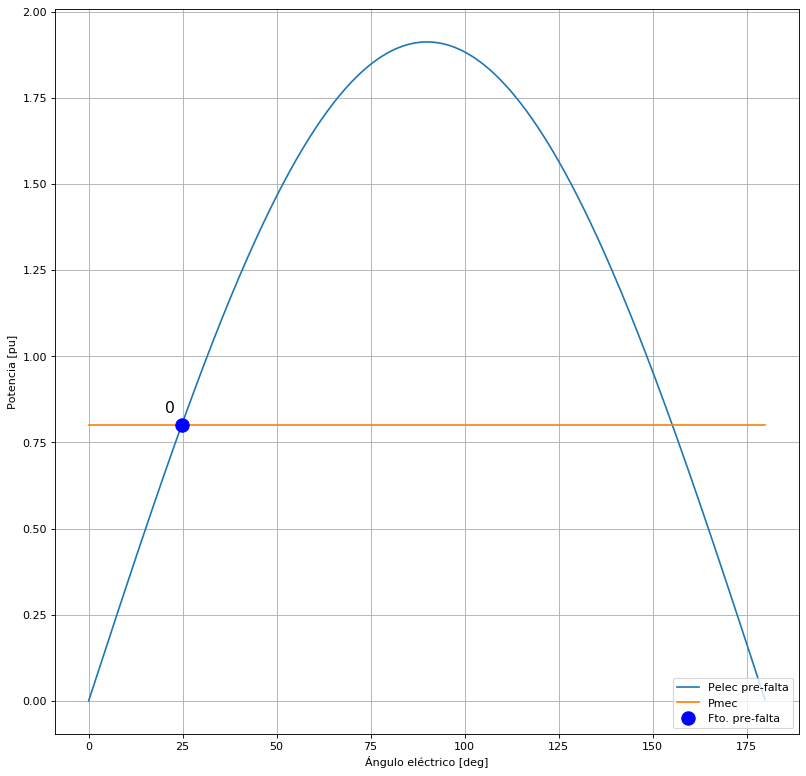

In [384]:
# Corriente inyectada por el generador antes de la falta:
sgen_comp = sgen*Gen*(FPgen+cm.sin(np.arccos(FPgen))*1j) # Potencia compleja entregada por el generador.
Pmec = sgen_comp.real # Potencia mecánica del generador.
print('Pmec = {:.3} pu.'.format(Pmec))
igen = sgen_comp.conjugate()/ugen.conjugate() # Corriente inyectada pre-falta.

# Tensión detrás de la reactancia transitoria del generador respecto de los bornes del mismo:
egen = ugen+Xgen*1j*igen
print('E_gen = {:.3} pu.'.format(egen))

# Tensión del nodo de conexión a red respecto de los bornes del generador:
ured = ugen - (Xt + XlA*XlB/(XlA + XlB))*1j*igen
print('U_red = {:.3} pu.'.format(ured))

# Ángulo relativo de la tensión detrás de la reactancia transitoria del generador con relación a la tensión del nudo de potencia infinita ANTES DE LA FALTA:
delta_0 = cm.phase(egen)-cm.phase(ured) # Ángulo de fase en sincronismo [rad].
delta_0_deg = delta_0*180/np.pi # [deg].
print('delta_pref = {:.3} deg.'.format(delta_0_deg))

# Impedancia de transferencia antes de la falta:
Xe_pref = Xgen + Xt + XlA*XlB/(XlA+XlB)
print('Xe_pref = {:.3} pu.'.format(Xe_pref))

# Potencia máxima transmisible antes de la falta:
Pmax_pref = abs(egen)*abs(ured)/Xe_pref
print('Pmax_pref = {:.3} pu.'.format(Pmax_pref))

# Potencia eléctrica:
delta = np.arange(0,np.pi,0.01)
delta_deg = delta*180/np.pi
pelec = abs(egen)*abs(ured)*np.sin(delta)/Xe_pref

# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

### Condiciones en falta

Durante el periodo de duración de la falta y el estado de los interruptores mantenido según las condiciones previas a la falta, puede transmitirse potencia entre el generador y la red a través de la línea A, no afectada por la falta trifásica en el punto **F**. Debe calcularse entonces la **impedancia de transferencia** entre la fuerza electromotriz del generador y el nudo de potencia infinita.

La impedancia de transferencia es la impedancia serie, sin ramas en paralelo, entre los nudos analizados, en este caso los nudos **0** (antes de la impedancia interna del generador) y **3**. Para su determinación deberán realizarse las transformaciones necesarias del circuito, en este caso una **transformación ESTRELLA > TRIÁNGULO**.

$$X_{03,fcc}=X'_{G}+X_{T1}+X_{L23A}+\displaystyle\frac{\left(X'_{G}+X_{T1}\right)X_{L23A}}{X_{L23B}/2}\neq 0.$$

Obsérvese que en situación de falta, el sistema sigue siendo capaz de transferir potencia, aunque de forma limitada.

![Sistema en falta](T09P02_Fig01.png)

![Sistema en falta equivalente](T09P02_Fig02.png)

Xe_f = 1.55 pu.
Pmax_f = 0.678 pu.


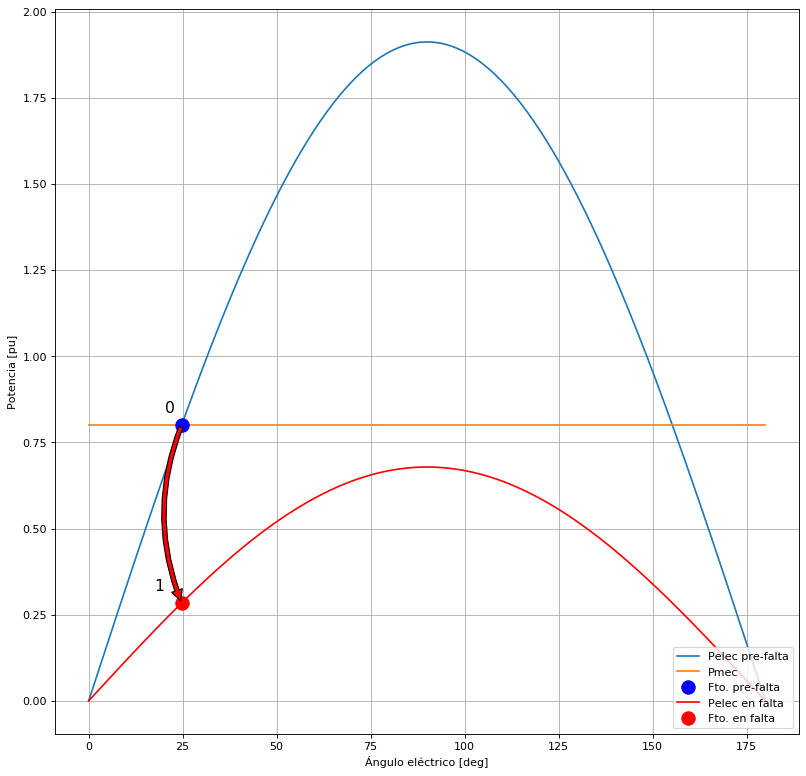

In [385]:
# Impedancia de transferencia en falta:
Xe_f = Xgen + Xt + XlA + (Xgen + Xt)*XlA/(dist_falta*XlB)
print('Xe_f = {:.3} pu.'.format(Xe_f))

# Potencia máxima transmisible en falta:
Pmax_f = abs(egen)*abs(ured)/Xe_f
print('Pmax_f = {:.3} pu.'.format(Pmax_f))

# Potencia eléctrica en falta:
delta = np.arange(0,np.pi,0.01)
delta_deg = delta*180/np.pi
pelecf = abs(egen)*abs(ured)*np.sin(delta)/Xe_f

# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica en falta:
fpelecf = plt.plot(delta_deg, pelecf, color='red', label = 'Pelec en falta') 

# Punto de operación en falta:
p2x = delta_0_deg
p2y = abs(egen)*abs(ured)*np.sin(delta_0)/Xe_f
p2 = plt.plot([p2x], [p2y], 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x-6, p2y+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x, p2y), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    
# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

Si la nueva **curva característica eléctrica** en falta a la **curva característica mecánica** durante el tiempo de permanencia de la falta nunca podrá sincronizarse de forma natual el generador. En caso contrario, el ángulo eléctrico $\delta$ evolucionaría hasta el punto de corte con la característica mecánica (acumulando energía aceleradora) y  posteriormente deceleraría hasta el punto de máxima oscilación, en el cual, la energía (área) deceleradora igualaría a la energía (área) aceleradora acumulada. En caso de que no se dispusiera de suficiente área deceleradora y no se modificara la curva característica eléctrica, el sistema sería inestable. 

En caso de existir suficiente área deceleradora, el sistema alcanzaría el punto de máxima oscilación y retornaría hasta que, pasado el punto de corte de las curvas características, se acumulara tanta área aceleradora como deceleradora, es decir, retornaría a $\delta_0$ y oscilaría permanentemente entre estos dos puntos de oscilación. En caso de existencia de factor de amortiguamiento no nulo, la amplitud de las oscilaciones dismuniría con el tiempo y el sistema se estabilizaría en el nuevo punto de corte de las curvas características.

### Condiciones post-falta

Detectada la falta por los sistemas de protección, la operación habitual para evitar la existencia de una corriente de cortocircuito de forma permanente en el sistema, sería abrir la línea afectada, en este caso la línea 23B, mediante la apertura de los interruptores de línea (I1B y I2B). Hecho esto, el circuito quedaría, según se muestra en la figura, con capacidad de transmisión de potencia a través de la línea 23A, pero con una **nueva impedancia de transferencia** distinta a las correspondientes a las situaciones pre-falta y en falta:

$$X_{03,fapertura}=X'_{G}+X_{T1}+\displaystyle\frac{X_{L23A} \left(X_{I1}+X_{L23B}+X_{I2}\right)}{X_{L23A}+\left(X_{I1}+X_{L23B}+X_{I2}\right)}=X'_{G}+X_{T1}+X_{L23A}.$$

![Sistema abierto](T09P02_Fig03.png)

Por este motivo, durante la falta y apertura de la línea, la potencia eléctrica transmisible varía dependiendo de la situación en la que se encuentre el sistema y tendrá un carácter limitado, pero no nulo.

Xe_posf = 0.65 pu.
Pmax_posf = 1.62 pu.


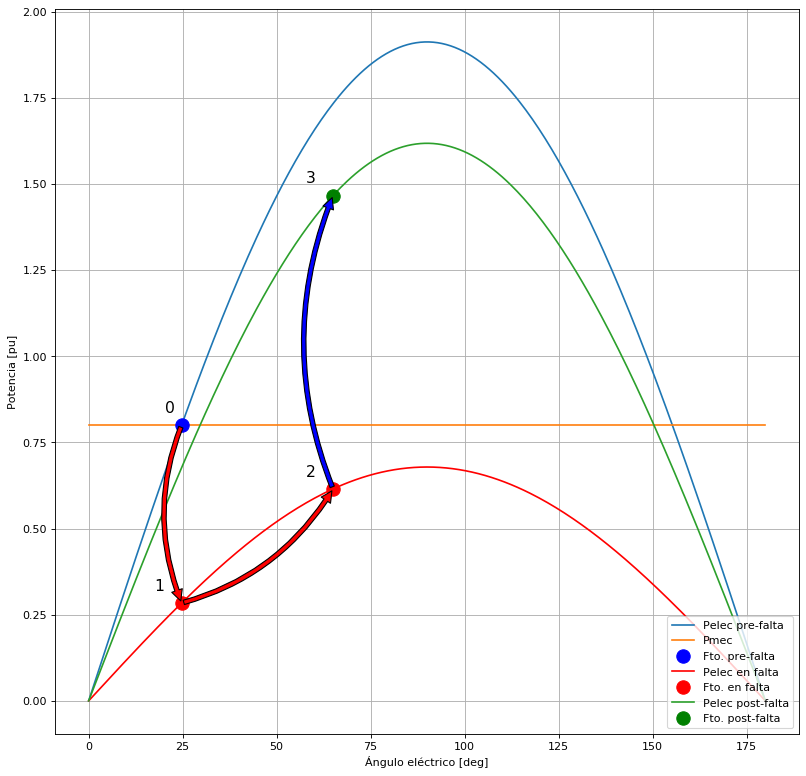

In [386]:
# Ángulo de despeje de la falta = apertura del interruptor:
delta_desp_deg = 65 # [deg].
delta_desp = delta_desp_deg*np.pi/180 # [rad].

# Impedancia de transferencia después de la falta:
Xe_posf = Xgen + Xt + XlA
print('Xe_posf = {:.3} pu.'.format(Xe_posf))

# Potencia máxima transmisible post-falta:
Pmax_posf = abs(egen)*abs(ured)/Xe_posf
print('Pmax_posf = {:.3} pu.'.format(Pmax_posf))

# Potencia eléctrica post-falta:
delta = np.arange(0,np.pi,0.01)
delta_deg = delta*180/np.pi
pelecposf = abs(egen)*abs(ured)*np.sin(delta)/Xe_posf

# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica en falta:
fpelecf = plt.plot(delta_deg, pelecf, color='red',label = 'Pelec en falta') 

# Punto de operación en falta:
p2x = np.array([delta_0_deg, delta_desp_deg])
p2y = np.array([abs(egen)*abs(ured)*np.sin(delta_0)/Xe_f, abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_f])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-6, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], p2y[0]), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.text (p2x[1]-6, p2y[1]+0.05, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Curva de potencia eléctrica post-falta:
fpelecposf = plt.plot(delta_deg, pelecposf, label = 'Pelec post-falta') 

# Punto de operación post-falta:
p3x = delta_desp_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_posf
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Fto. post-falta')
## Anotaciones:
if anotaciones:
    plt.text (p3x-6, p3y+0.05, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))
 
# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

### Áreas aceleradora y deceleradora máxima

En este punto téngase en cuenta que, al ser la curva característica eléctrica pre-falta distinta de la post-falta, el ángulo máximo para el área deceleradora está marcado por la nueva curva, pudiéndose obtener mediante:

$$\delta_{max}=\pi-\arcsin\left(\displaystyle\frac{P_{mec}Xe_{posf}}{E\cdot U}\right).$$

In [387]:
# Ángulo máximo para el área deceleradora:
delta_0_posf = np.arcsin(sgen_comp.real*Xe_posf/(abs(egen)*abs(ured))) # [rad].
delta_0_posf_deg = delta_0_posf*180/np.pi # [deg].
delta_max = np.pi-delta_0_posf # [rad].
delta_max_deg = delta_max*180/np.pi # [deg].
print('delta_max: {:.3f} pu.'.format(delta_max_deg))

# Cálculo del área aceleradora:
## Potencia aceleradora en función del ángulo eléctrico:
def Pacel(delta,Pmec,Pmax_f):
    pacel = Pmec-Pmax_f*np.sin(delta)
    return pacel

## Área aceleradora:
def Aacel(delta_1,delta_2):
    aacel = integrate.quad(Pacel, delta_1, delta_2, args=(Pmec,Pmax_f,))
    return aacel[0]

Area_acel = Aacel(delta_0, delta_desp)
print('Área aceleradora: {:.4} pu.'.format(Area_acel))

# Cálculo del área deceleradora máxima:
## Potencia deceleradora en función del ángulo eléctrico:
def Pdecel(delta,Pmec,Pmax_posf):
    pdecel = Pmax_posf*np.sin(delta)-Pmec
    return pdecel

## Área deceleradora máxima:
def Adecel(delta_1,delta_2):
    adecel = integrate.quad(Pdecel, delta_1, delta_2, args=(Pmec,Pmax_posf,))
    return adecel[0]

Area_decel_max = Adecel(delta_desp, delta_max)
print('Área deceleradora máxima: {:.4} pu.'.format(Area_decel_max))

delta_max: 150.361 pu.
Área aceleradora: 0.2327 pu.
Área deceleradora máxima: 0.8978 pu.


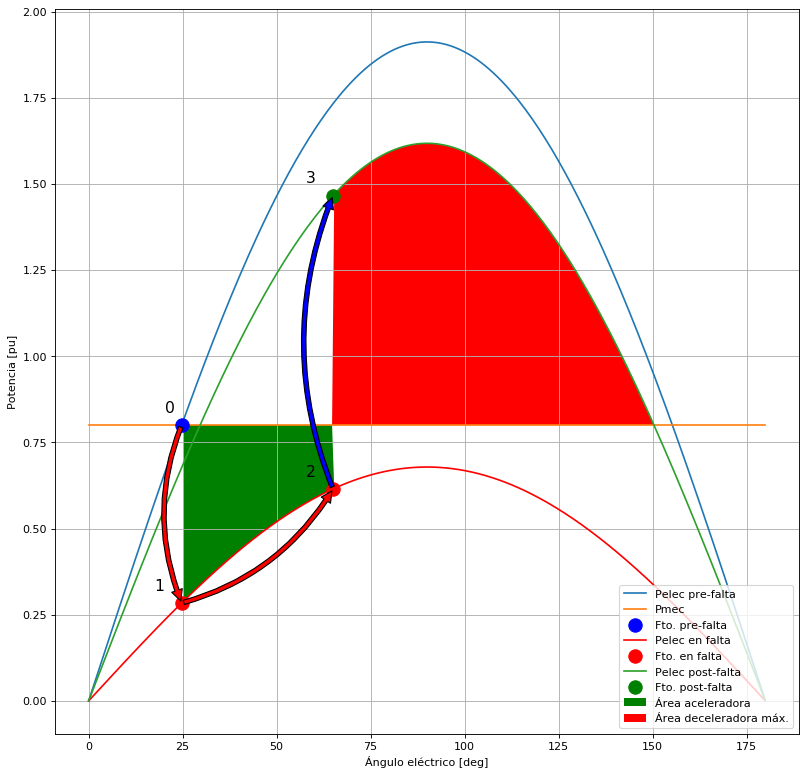

In [388]:
# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica en falta:
fpelecf = plt.plot(delta_deg, pelecf, color='red', label = 'Pelec en falta') 

# Punto de operación en falta:
p2x = np.array([delta_0_deg, delta_desp_deg])
p2y = np.array([abs(egen)*abs(ured)*np.sin(delta_0)/Xe_f, abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_f])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-6, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], p2y[0]), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.text (p2x[1]-6, p2y[1]+0.05, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Curva de potencia eléctrica post-falta:
fpelecposf = plt.plot(delta_deg, pelecposf, label = 'Pelec post-falta') 

# Punto de operación post-falta:
p3x = delta_desp_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_posf
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Fto. post-falta')
## Anotaciones:
if anotaciones:
    plt.text (p3x-6, p3y+0.05, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,p2x[1])
plt.fill_between(delta_deg2, pelecf, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Área deceleradora máxima:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_max_deg)
plt.fill_between(delta_deg3, pmec, pelecposf, where = delta_deg3 >= p2x[1], facecolor='red', interpolate=True, label='Área deceleradora máx.')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

Al ser el área aceleradora menor que el área deceleradora, el sistema podrá alcanzar la estabilidad y el desplazamiento máximo del ángulo será menor que el ángulo máximo:

$$\delta_{max}\leq \pi-\delta_{0,posf}.$$

### Ángulo de oscilación máximo

In [389]:
# Función del residuo de la diferencia de áreas aceleradora y deceleradora en función del ángulo de reconexión delta:
def IgualdadAreas(delta):
    return (Area_acel-Adecel(delta_desp,delta))**2

# Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = delta_desp # Valor semilla.
bnd_x1 = 1.001*delta_desp # Límite inferior (restricción).
bnd_x2 = delta_max # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt = optim.minimize(IgualdadAreas,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
delta_1 = delta_opt[0] # [rad].
delta_1_deg = delta_1*180/np.pi # [deg].
print('El ángulo de oscilación máximo es: {:.3f} deg'.format(delta_1_deg))
print('Error: {}'.format((Area_acel-Adecel(delta_desp,delta_1))**2))

El ángulo de oscilación máximo es: 82.826 deg
Error: 1.156841960880532e-15


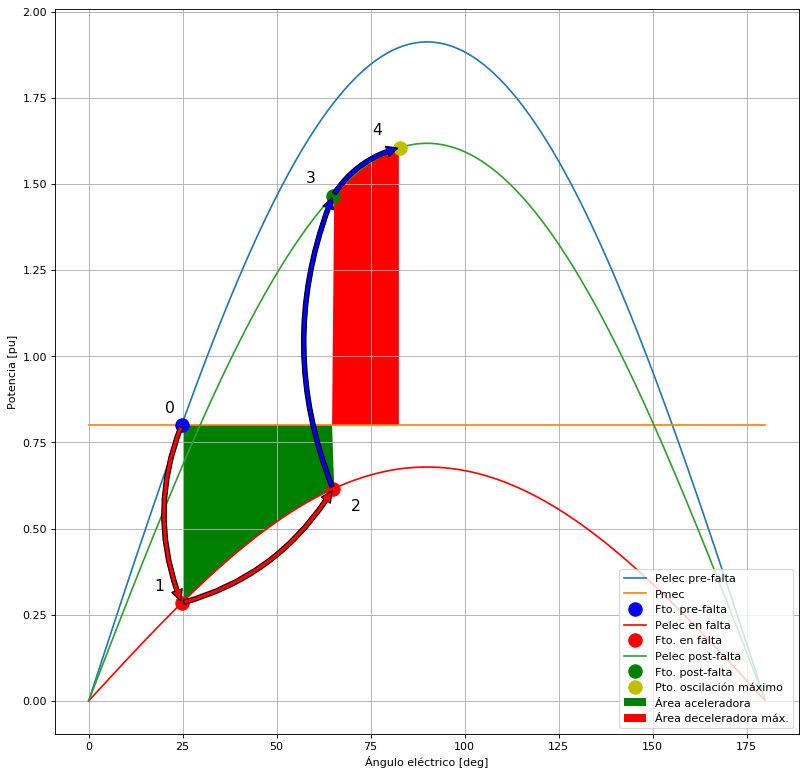

In [390]:
# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica en falta:
fpelecf = plt.plot(delta_deg, pelecf, color='red', label = 'Pelec en falta') 

# Punto de operación en falta:
p2x = np.array([delta_0_deg, delta_desp_deg])
p2y = np.array([abs(egen)*abs(ured)*np.sin(delta_0)/Xe_f, abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_f])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-6, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], p2y[0]), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.text (p2x[1]+6, p2y[1]-0.05, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Curva de potencia eléctrica post-falta:
fpelecposf = plt.plot(delta_deg, pelecposf, label = 'Pelec post-falta') 

# Punto de operación post-falta:
p3x = delta_desp_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_posf
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Fto. post-falta')
## Anotaciones:
if anotaciones:
    plt.text (p3x-6, p3y+0.05, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Punto de oscilación máxima:
p4x = delta_1_deg
p4y = abs(egen)*abs(ured)*np.sin(delta_1)/Xe_posf
p4 = plt.plot([p4x], [p4y], 'yo', markersize=12, label = 'Pto. oscilación máximo')
## Anotaciones:
if anotaciones:
    plt.text (p4x-6, p4y+0.05, '4', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p4x, p4y), xytext=(p3x, p3y), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))
    
# Área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,p2x[1])
plt.fill_between(delta_deg2, pelecf, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Área deceleradora:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_1_deg)
plt.fill_between(delta_deg3, pmec, pelecposf, where = delta_deg3 >= p2x[1], facecolor='red', interpolate=True, label='Área deceleradora máx.')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

### Cálculo del ángulo crítico

In [391]:
# Función del residuo de la diferencia de áreas aceleradora y deceleradora en función del ángulo de reconexión delta:
def IgualdadAreas2(delta):
    return (Aacel(delta_0,delta)-Adecel(delta,delta_max))**2

## Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = (delta_0+delta_max)/2 # Valor semilla.
bnd_x1 = delta_0 # Límite inferior (restricción).
bnd_x2 = delta_max # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt = optim.minimize(IgualdadAreas2,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
delta_cri = delta_opt[0] # rad.
delta_cri_deg = delta_cri*180/np.pi # deg.
print('El ángulo crítico calculado es: {:.3f} deg'.format(delta_cri_deg))

El ángulo crítico calculado es: 106.585 deg


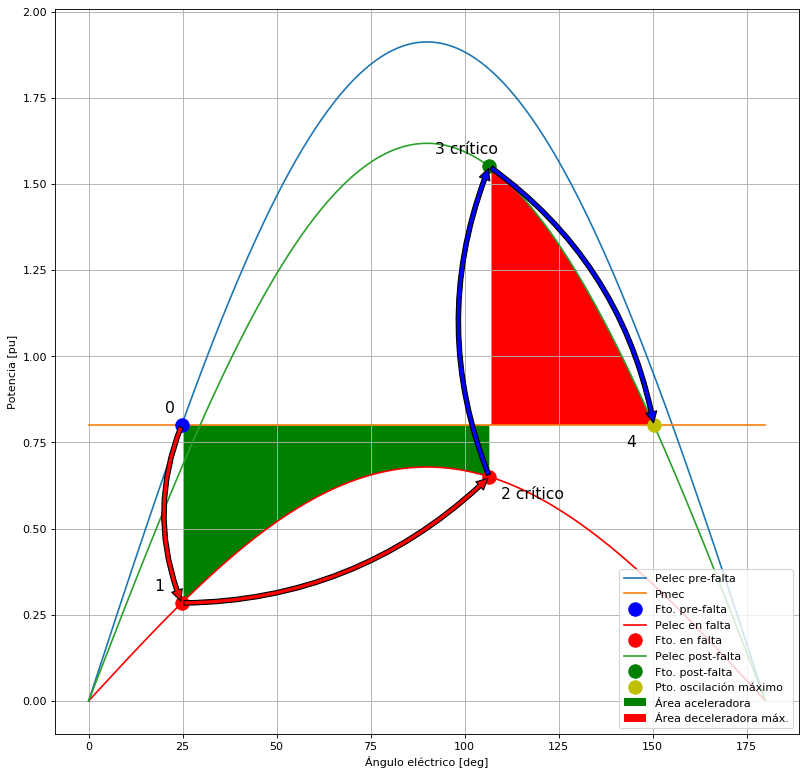

In [392]:
# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica en falta:
fpelecf = plt.plot(delta_deg, pelecf, color='red', label = 'Pelec en falta') 

# Punto de operación en falta:
p2x = np.array([delta_0_deg, delta_cri_deg])
p2y = np.array([abs(egen)*abs(ured)*np.sin(delta_0)/Xe_f, abs(egen)*abs(ured)*np.sin(delta_cri)/Xe_f])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-6, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], p2y[0]), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.text (p2x[1]+3, p2y[1]-0.05, '2 crítico', fontsize=14, horizontalalignment='left', verticalalignment='center')
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Curva de potencia eléctrica post-falta:
fpelecposf = plt.plot(delta_deg, pelecposf, label = 'Pelec post-falta') 

# Punto de operación post-falta:
p3x = delta_cri_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_cri)/Xe_posf
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Fto. post-falta')
## Anotaciones:
if anotaciones:
    plt.text (p3x-6, p3y+0.05, '3 crítico', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Punto de oscilación máxima:
p4x = delta_max_deg
p4y = abs(egen)*abs(ured)*np.sin(delta_max)/Xe_posf
p4 = plt.plot([p4x], [p4y], 'yo', markersize=12, label = 'Pto. oscilación máximo')
## Anotaciones:
if anotaciones:
    plt.text (p4x-6, p4y-0.05, '4', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p4x, p4y), xytext=(p3x, p3y), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))
    
# Área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,p2x[1])
plt.fill_between(delta_deg2, pelecf, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Área deceleradora:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_max_deg)
plt.fill_between(delta_deg3, pmec, pelecposf, where = delta_deg3 >= p2x[1], facecolor='red', interpolate=True, label='Área deceleradora máx.')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

### Oscilación debida al nuevo desequilibrio Pelec > Pmec

Salvo que se despejara la falta justo en el ángulo crítico y, por lo tanto, el ángulo de oscilación máximo fuera $\delta_{max}=\pi-\delta_{0,posf}$, caso en el que se encontraría un nuevo equilibrio al cumplirse en dicho punto de funcionamiento que $P_{elec}=P_{mec}$, el sistema aunque haya alcanzado la oscilación máxima (igualdad de áreas = igualdad de energía de aceleración y deceleración), estaría en desequilibrio ($P_{elec}>P_{mec}$) por lo que volvería a oscilar en sentido inverso.

In [393]:
# Cálculo del área deceleradora:
Area_decel_2 = Adecel(delta_0_posf, delta_1)
print('Área deceleradora 2: {:.4} pu.'.format(Area_decel_2))

# Potencia aceleradora en función del ángulo eléctrico (Pelec != 0):
def Pacel2(delta,Pmec,Pmax_posf):
    pacel = Pmec-Pmax_posf*np.sin(delta)
    return pacel

## Área aceleradora 2:
def Aacel2(delta_1,delta_2):
    aacel2 = integrate.quad(Pacel2, delta_1, delta_2, args=(Pmec,Pmax_posf))
    return aacel2[0]

# Función del residuo de la diferencia de áreas aceleradora y deceleradora en función del ángulo delta:
def IgualdadAreas3(delta):
    return (Aacel2(delta,delta_0)-Area_decel_2)**2

# Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = -np.pi/2 # Valor semilla.
bnd_x1 = -np.pi # Límite inferior (restricción).
bnd_x2 = 0 # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt2 = optim.minimize(IgualdadAreas3,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
delta_2 = delta_opt2[0] # [rad].
delta_2_deg = delta_2*180/np.pi # [deg].
print('El ángulo de oscilación máximo 2 es: {:.4f} deg'.format(delta_2_deg))

Área deceleradora 2: 0.4614 pu.
El ángulo de oscilación máximo 2 es: -14.9930 deg


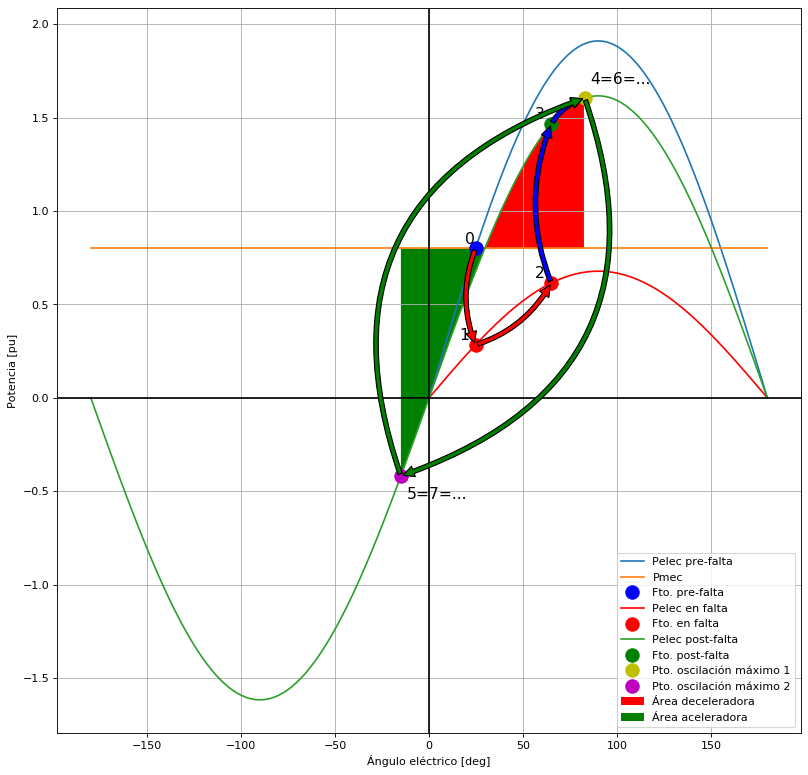

In [394]:
# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
delta2 = np.arange(-1*np.pi,np.pi,0.01)
delta2_deg = delta2*180/np.pi
pmec = sgen_comp.real*np.ones(np.size(delta2))
fpmec = plt.plot(delta2_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0_deg
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica en falta:
fpelecf = plt.plot(delta_deg, pelecf, color='red', label = 'Pelec en falta') 

# Punto de operación en falta:
p2x = np.array([delta_0_deg, delta_desp_deg])
p2y = np.array([abs(egen)*abs(ured)*np.sin(delta_0)/Xe_f, abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_f])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-6, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], p2y[0]), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.text (p2x[1]-6, p2y[1]+0.05, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Curva de potencia eléctrica post-falta:
pelecposf = abs(egen)*abs(ured)*np.sin(delta2)/Xe_posf
fpelecposf = plt.plot(delta2_deg, pelecposf, label = 'Pelec post-falta') 

# Punto de operación post-falta:
p3x = delta_desp_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_desp)/Xe_posf
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Fto. post-falta')
## Anotaciones:
if anotaciones:
    plt.text (p3x-6, p3y+0.05, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Punto de oscilación máximo 1:
p4x = delta_1_deg
p4y = abs(egen)*abs(ured)*np.sin(delta_1)/Xe_posf
p4 = plt.plot([p4x], [p4y], 'yo', markersize=12, label = 'Pto. oscilación máximo 1')
## Anotaciones:
if anotaciones:
    plt.text (p4x+3, p4y+0.1, '4=6=...', fontsize=14, horizontalalignment='left', verticalalignment='center')
    plt.annotate("", xy=(p4x, p4y), xytext=(p3x, p3y), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Punto de oscilación máximo 2:
p5x = delta_2_deg
p5y = abs(egen)*abs(ured)*np.sin(delta_2)/Xe_posf
p5 = plt.plot([p5x], [p5y], 'mo', markersize=12, label = 'Pto. oscilación máximo 2')
## Anotaciones:
if anotaciones:
    plt.text (p5x+3, p5y-0.1, '5=7=...', fontsize=14, horizontalalignment='left', verticalalignment='center')
    plt.annotate("", xy=(p5x, p5y), xytext=(p4x, p4y), size=20, va="center", ha="center", arrowprops=dict(facecolor='green',arrowstyle="simple",connectionstyle="arc3,rad=-0.5"))
    plt.annotate("", xy=(p4x, p4y), xytext=(p5x, p5y), size=20, va="center", ha="center", arrowprops=dict(facecolor='green',arrowstyle="simple",connectionstyle="arc3,rad=-0.5"))

# Área deceleradora:
delta_deg2 = np.ma.masked_less(delta2_deg, delta_0_posf_deg)
delta_deg2 = np.ma.masked_greater(delta_deg2, delta_1_deg)
plt.fill_between(delta_deg2, pmec, pelecposf, where = pelecposf >= pmec, facecolor='red', interpolate=True, label='Área deceleradora')

# Área aceleradora:
delta_deg3 = np.ma.masked_less(delta2_deg,delta_2_deg)
delta_deg3 = np.ma.masked_greater(delta_deg3,delta_0_posf_deg)
plt.fill_between(delta_deg3, pelecposf, pmec, where = pelecposf <= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')

# Imprimir ejes x=0 e y =0
plt.axvline(x=0, color = 'black') # x=0.
plt.axhline(y=0, color = 'black') # y=0.

plt.show()

Tras alcanzar el punto de oscilación máximo 2, la energía de las áreas se habría compensado pero el sistema estaría de nuevo en desequilibrio al ser $P_{elec} < P_{mec}$, por lo que el sistema retrocedería de nuevo, hasta el punto de oscilación máximo 1.

En ausencia de **amortiguamiento** el sistema se encontrará oscilando entre los puntos de oscilación máximos 1 y 2 calculados. Si exisitiera amortiguamiento (factor de amortiguamiento $D$ no nulo), las oscilaciones se irían reduciendo hasta converger al punto de equilibrio original (suponiendo que $P_{mec}$ se mantuviera). **Obsérvese que el nuevo punto de equilibrio que se alcanzaría sería distinto del original al encontrarse en una curva característica nueva (característica post-falta)**.

Obsérvese que valores negativos de $P_{elec}$ implicarían que el generador estaría consumiendo potencia activa, en lugar de cederla (para conseguir frenarse, el generador estaría actuando como motor de la turbina).

### Límites de frecuencia alcanzados

De acuerdo a los puntos máximos de oscilación el generador alcanzará una frecuencia máxima/sobrefrecuencia y una frecuencia mínima/subfrecuencia. Obsérvese que estos puntos extremos se alcanzan cuando el sistema pasa por el ángulo $\delta_0$, mientras que la frecuencia en los puntos de oscilación 1 y 2, es la frecuencia original del sistema ($50\mbox{ Hz}$).

In [395]:
# Frecuencia original:
frec_0 = omega_0/(2*np.pi)
print('Frecuencia origen: {:.4f} Hz.'.format(frec_0))

# Frecuencia en el punto de reconexión:
## Potencia aceleradora en función del ángulo eléctrico:
def Pacel(delta,egen,ured,Xe_f,sgen_comp):
    pacel = sgen_comp.real-abs(egen)*abs(ured)*np.sin(delta)/Xe_f
    return pacel

## Área aceleradora:
def Aacel(delta_1,delta_2):
    aacel = integrate.quad(Pacel, delta_1, delta_2, args=(egen,ured,Xe_f,sgen_comp))
    return aacel[0]

omega_desp = omega_0+((omega_0/H)*Aacel(delta_0, delta_desp))**0.5
frec_desp = omega_desp/(2*np.pi)
print('Frecuencia alcanzada en el punto de reconexión del generador: {:.4f} Hz.'.format(frec_desp))

# Frecuencia en el punto de oscilación máximo 1:
omega_1 = omega_desp-((omega_0/H)*Adecel(delta_desp, delta_1))**0.5
frec_1 = omega_1/(2*np.pi)
print('Frecuencia alcanzada en el punto de oscilación máximo 1: {:.4f} Hz.'.format(frec_1))

# Frecuencia en el punto origen:
omega_2 = omega_1-((omega_0/H)*Adecel(delta_0_posf, delta_1))**0.5
frec_2 = omega_2/(2*np.pi)
print('Frecuencia alcanzada al pasar de osc. máx. 1 a osc. máx. 2 por el punto origen: {:.4f} Hz.'.format(frec_2))

# Frecuencia en el punto de oscilación máximo 2:
omega_3 = omega_2+((omega_0/H)*Aacel2(delta_2, delta_0_posf))**0.5
frec_3 = omega_3/(2*np.pi)
print('Frecuencia alcanzada en el punto de oscilación máximo 2: {:.4f} Hz.'.format(frec_3))

# Frecuencia en el punto origen:
omega_4 = omega_3+((omega_0/H)*Aacel2(delta_2, delta_0_posf))**0.5
frec_4 = omega_4/(2*np.pi)
print('Frecuencia alcanzada al pasar de osc. máx. 2 a osc. máx. 1 por el punto origen: {:.4f} Hz.'.format(frec_4))

# Frecuencia en el punto de oscilación máximo 1:
omega_5 = omega_4-((omega_0/H)*Adecel(delta_0_posf, delta_1))**0.5
frec_5 = omega_5/(2*np.pi)
print('Frecuencia alcanzada en el punto de oscilación máximo 1: {:.4f} Hz.'.format(frec_5))

Frecuencia origen: 50.0000 Hz.
Frecuencia alcanzada en el punto de reconexión del generador: 50.7857 Hz.
Frecuencia alcanzada en el punto de oscilación máximo 1: 50.0000 Hz.
Frecuencia alcanzada al pasar de osc. máx. 1 a osc. máx. 2 por el punto origen: 48.8937 Hz.
Frecuencia alcanzada en el punto de oscilación máximo 2: 50.0062 Hz.
Frecuencia alcanzada al pasar de osc. máx. 2 a osc. máx. 1 por el punto origen: 51.1188 Hz.
Frecuencia alcanzada en el punto de oscilación máximo 1: 50.0125 Hz.


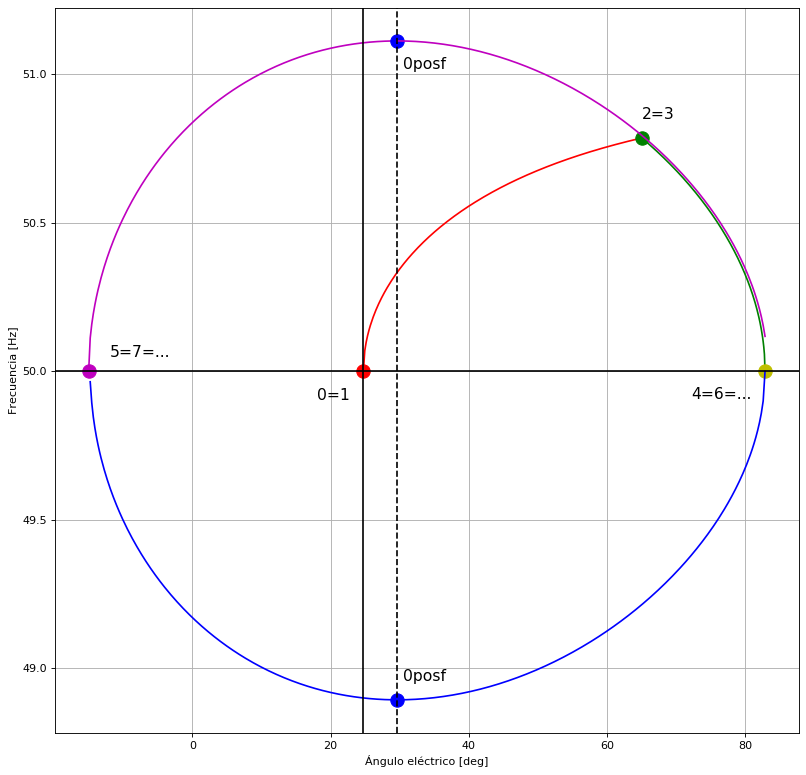

In [396]:
# Representación gráfica:
anotaciones = True
fig8 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Ángulo eléctrico [deg]')

# Valores de frecuencia alcanzados en función del ángulo durante el período en falta:
delta3 = np.linspace(delta_0,delta_desp,200)
delta3_deg = delta3*180/np.pi
omega_0desp = np.zeros(np.size(delta3))
for i in range(np.size(delta3)):
    omega_0desp[i] = omega_0+((omega_0/H)*Aacel(delta_0, delta3[i]))**0.5
    
frec_0desp = omega_0desp/(2*np.pi)
p1 = plt.plot(delta3_deg, frec_0desp,'r')
if anotaciones:
    plt.plot(delta3_deg[0], frec_0desp[0],'ro', markersize=12)
    plt.text (delta3_deg[0]-2, frec_0desp[0]-0.08, '0=1', fontsize=14, horizontalalignment='right', verticalalignment='center')
    plt.plot(delta3_deg[-1], frec_0desp[-1],'go', markersize=12)
    plt.text (delta3_deg[-1], frec_0desp[-1]+0.08, '2=3', fontsize=14, horizontalalignment='left', verticalalignment='center')

# Valores de frecuencia alcanzados tras la reconexión hasta el punto de oscilación máxima 1:
delta4 = np.linspace(delta_desp,delta_1,200)
delta4_deg = delta4*180/np.pi
omega_desp1 = np.zeros(np.size(delta4))
for i in range(np.size(delta4)):
    omega_desp1[i] = omega_0+((omega_0/H)*(Aacel(delta_0,delta_desp)-Adecel(delta_desp, delta4[i])))**0.5

frec_desp1 = omega_desp1/(2*np.pi)
p2 = plt.plot(delta4_deg, frec_desp1,'g')
if anotaciones:
    plt.plot(delta4_deg[-1], frec_desp1[-1],'yo', markersize=12)
    plt.text (delta4_deg[-1]-2, frec_desp1[-1]-0.08, '4=6=...', fontsize=14, horizontalalignment='right', verticalalignment='center')
    
# Valores de frecuencia alcanzados desde el punto de oscilación máxima 1 hasta el punto origen:
delta5 = np.linspace(delta_0_posf,delta_1,200)
delta5_deg = delta5*180/np.pi
omega_10 = np.zeros(np.size(delta5))
for i in range(np.size(delta5)):
    omega_10[i] = omega_0-((omega_0/H)*Adecel(delta5[i], delta_1))**0.5

frec_10 = omega_10/(2*np.pi)
p3 = plt.plot(delta5_deg, frec_10,'b')
if anotaciones:
    plt.plot(delta5_deg[0], frec_10[0],'bo', markersize=12)
    plt.text (delta5_deg[0]+7, frec_10[0]+0.08, '0posf', fontsize=14, horizontalalignment='right', verticalalignment='center')

# Valores de frecuencia alcanzados desde el punto origen hasta el punto de oscilación máxima 2:
delta6 = np.linspace(delta_2,delta_0_posf,200)
delta6_deg = delta6*180/np.pi
omega_02 = np.zeros(np.size(delta6))
for i in range(np.size(delta6)):
    omega_02[i] = omega_0-((omega_0/H)*np.abs(Adecel(delta_0_posf, delta_1)-Aacel2(delta6[i], delta_0_posf)))**0.5

frec_02 = omega_02/(2*np.pi)
p4 = plt.plot(delta6_deg[1:], frec_02[1:],'b')
if anotaciones:
    plt.plot(delta6_deg[0], frec_0,'mo', markersize=12)
    plt.text (delta6_deg[0]+3, frec_02[0]+0.18, '5=7=...', fontsize=14, horizontalalignment='left', verticalalignment='center')

# Valores de frecuencia alcanzados desde el punto de oscilación máxima 2 hasta el punto origen:
omega_20 = np.zeros(np.size(delta6))
for i in range(np.size(delta6)):
    omega_20[i] = omega_0+((omega_0/H)*Aacel2(delta_2, delta6[i]))**0.5

frec_20 = omega_20/(2*np.pi)
p5 = plt.plot(delta6_deg, frec_20,'m')
if anotaciones:
    plt.plot(delta6_deg[-1], frec_20[-1],'bo', markersize=12)
    plt.text (delta6_deg[-1]+7, frec_20[-1]-0.08, '0posf', fontsize=14, horizontalalignment='right', verticalalignment='center')

# Valores de frecuencia alcanzados desde el punto origen hasta el punto de oscilación máxima 1:
omega_01 = np.zeros(np.size(delta5))
for i in range(np.size(delta5)):
    omega_01[i] =  omega_0+((omega_0/H)*np.abs(Adecel(delta_0_posf, delta5[i])-Aacel2(delta_2, delta_0_posf)))**0.5

frec_01 = omega_01/(2*np.pi)
p6 = plt.plot(delta5_deg, frec_01,'m')

# Eje x=delta_0:
plt.axvline(x=delta_0_deg, color = 'black')

# Eje x=delta_0posf:
plt.axvline(x=delta_0_posf_deg, linestyle='--', color = 'black')

# Eje y=frec_0:
plt.axhline(y=frec_0, color = 'black')

plt.show()

**NOTA:** Los pequeños errores por el cálculo de áreas y ángulos máximos de oscilación por métodos numéricos explican las diferencias encontradas entre los valores obtenidos y los valores teóricos.